<a href="https://colab.research.google.com/github/bofori-tech/DS-Unit-2-Applied-Modeling/blob/master/unit2%2CSprint3%2CModule1_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
 !pip install category_encoders==2.*

     |████████████████████████████████| 81kB 2.1MB/s 


In [2]:
!wget https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/COVID%20-%20City%20-%20Daily.csv

--2020-10-07 01:30:38--  https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/COVID%20-%20City%20-%20Daily.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571229 (558K) [text/plain]
Saving to: ‘COVID - City - Daily.csv’

COVID - City - Dail 100%[===================>] 557.84K  --.-KB/s    in 0.09s   

2020-10-07 01:30:39 (5.82 MB/s) - ‘COVID - City - Daily.csv’ saved [571229/571229]



In [8]:
import pandas as pd
df= pd.read_csv('COVID - City - Daily.csv')
print(df.shape)
df.head()

(13409, 12)


,year,month,day,cityid,case_count,death_count,new_death_count,new_case_count,case_rate,death_rate,new_case_rate,new_death_rate
0,2020,1,21,1,0,0,0,0,0.0,0.0,.,.
1,2020,1,21,2,0,0,0,0,0.0,0.0,.,.
2,2020,1,21,3,0,0,0,0,0.0,0.0,.,.
3,2020,1,21,4,0,0,0,0,0.0,0.0,.,.
4,2020,1,21,5,0,0,0,0,0.0,0.0,.,.


In [9]:
df.tail()

,year,month,day,cityid,case_count,death_count,new_death_count,new_case_count,case_rate,death_rate,new_case_rate,new_death_rate
13404,2020,9,29,49,12994,147,0,52,2698.0,30.5,15.5,0
13405,2020,9,29,50,31345,254,2,266,2701.0,21.9,32.9,.0739
13406,2020,9,29,51,6901,91,0,43,1534.0,20.2,7.21,.317
13407,2020,9,29,52,6955,175,1,36,965.0,24.3,3.15,.0793
13408,2020,9,29,53,17207,162,2,203,2641.0,24.9,21.9,.197


In [10]:
df['case_rate'].describe()

count    13409.000000
mean       782.234660
std        972.821658
min          0.000000
25%          8.140000
50%        303.000000
75%       1347.000000
max       6260.000000
Name: case_rate, dtype: float64

In [12]:
df = df.dropna(subset=['case_rate'])
df['High_cases'] = df['case_rate'] >= 300

In [13]:
# There are 2 classes, this is a binary classification problem. 
y = df['High_cases']
y.nunique()

2

In [14]:
y.value_counts(normalize=True)

True     0.501529
False    0.498471
Name: High_cases, dtype: float64

In [15]:
# How many kinds of burritos?
df['cityid'].nunique()

53

In [17]:
# What kinds of burritos?
df['cityid'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53])

In [18]:
# Count the missing values
df.isna().sum().sort_values()

year               0
month              0
day                0
cityid             0
case_count         0
death_count        0
new_death_count    0
new_case_count     0
case_rate          0
death_rate         0
new_case_rate      0
new_death_rate     0
high               0
High_cases         0
dtype: int64

In [32]:
from sklearn.model_selection import train_test_split
df['day'] = pd.to_datetime(df['day'])
cutoff = pd.to_datetime(22)
train = df[df.day < cutoff]
test  = df[df.day >= cutoff]

# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, random_state=42)
                            
train.shape, val.shape, test.shape

((7165, 14), (1792, 14), (4452, 14))

In [37]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

target = 'High_cases'
features = train.columns.drop([target, 'day', 'case_rate'])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    # imputer
    DecisionTreeClassifier(max_depth=3)
)

pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 1.0


In [40]:
from sklearn.metrics import roc_auc_score
y_pred_proba = pipeline.predict_proba(X_val)[:,1]
y_pred_proba
# roc_auc_score(y_val, y_pred_proba)

array([0., 0., 0., ..., 0., 0., 1.])

In [41]:
# Use sklearn to calculate TPR & FPR at various thresholds
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [42]:
# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.0,0.0,2.0
1,0.0,1.0,1.0
2,1.0,1.0,0.0


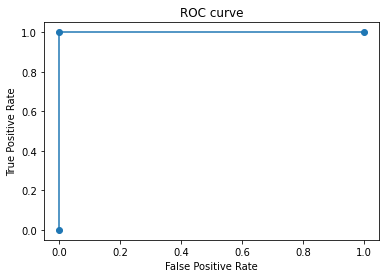

In [43]:
# See the results on a plot.
# This is the "Receiver Operating Characteristic curve"
import matplotlib.pyplot as plt
plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');